In [50]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

--2023-05-13 14:49:07--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.10’

input.txt.10        100%[===================>]   1.06M  4.94MB/s    in 0.2s    

2023-05-13 14:49:07 (4.94 MB/s) - ‘input.txt.10’ saved [1115394/1115394]



In [51]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [52]:
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [53]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [54]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [55]:
# Now that we have an encoder, we can encode the entire dataset:
data = torch.tensor(encode(text), dtype=torch.long, device=device)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


Next we can split our dataset into training and validation datasets:


In [56]:
spl = int(0.9 * len(data))

train_data = data[:spl]

val_data = data[spl:]

Our input data will contain mini-batches of blocks on tokens with block size <= block_size:

In [57]:
torch.manual_seed(1337)

batch_size = 4
context_length = 8

def get_batch(split, batch_size, context_length):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i:i+context_length] for i in ix])
    y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return x, y

xb, yb = get_batch('train', batch_size, context_length)

print('inputs:')
print(xb.shape)
print(xb)
print(yb.shape)
print(yb)
print('----')

for b in range(batch_size):
    for t in range(context_length):
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f'when input is {context.tolist()} the target: {target}')



inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53, 56, 1, 

Now that we have our input/label generation sorted, we can start training a model. We can start with the BigramLanguageModel we've implemented in previous lectures as a baseline. We simply look up a probabilitiy distribution in the token embedding table and use that to predict the next character.

In [77]:
def train(model, num_steps, batch_size, context_length, learning_rate=1e-3, optimizer=None, print_every=1000):
    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    model.train()
    losses = []
    for step in range(1, num_steps+1):
        optimizer.zero_grad()
        x, y = get_batch('train', batch_size, context_length)
        logits, loss = model(x, y)
        loss.backward()
        optimizer.step()
        if step % print_every == 0:
            print(f'step {step}: loss {loss.item()}')
        losses.append(loss.item())

    return losses


def plot_ema(losses, gamma=0.99, title='ema'):
    ema = losses[0]
    ema_losses = []
    for i, l in enumerate(losses):
        ema = gamma * ema + (1-gamma) * l
        ema_losses.append(ema)
    plt.plot(ema_losses, label='loss ema', color='red')
    plt.legend()
    plt.show()
    print('final loss (ema):', ema_losses[-1])

def generate_text(model, starting_text=' ', max_new_tokens=100):
    data = torch.tensor(encode(starting_text), dtype=torch.long, device=device).reshape(-1, 1)
    model.eval()
    with torch.no_grad():
        print(starting_text + decode(model.generate(data, max_new_tokens=max_new_tokens)[0].tolist()))
    model.train()

In [70]:
torch.zeros((1,1), dtype=torch.long, device=device).shape

torch.Size([1, 1])

In [ ]:
import torch.nn as nn
from torch.nn import functional as F

class BigramLangugageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) # batch, timestep, channel

        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

m = BigramLangugageModel(vocab_size).to(device)
out, loss = m(xb, yb)
print('loss:', loss)
print(out.shape)
generate_text(m)

In previous lectures we've implemented our own simple SGD optimizer -- this time we can just use one of PyTorch's built-in optimizers:

We can use the optimizer to train the Bigram model over a few steps:

step 1000: loss 3.679224729537964
step 2000: loss 3.0610170364379883
step 3000: loss 2.72971773147583
step 4000: loss 2.545755386352539
step 5000: loss 2.509843349456787
step 6000: loss 2.4547369480133057
step 7000: loss 2.4333791732788086
step 8000: loss 2.4855430126190186
step 9000: loss 2.4706852436065674
step 10000: loss 2.466132879257202


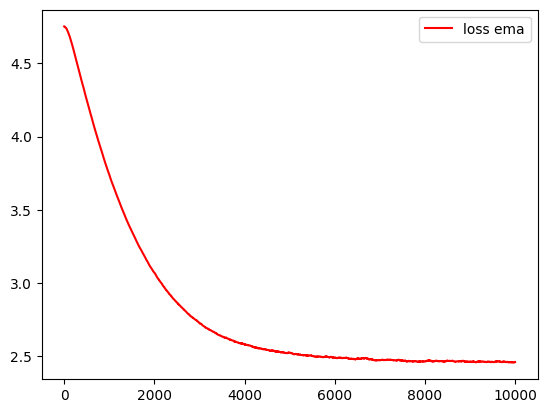

final loss (ema): 2.460625844800048


In [79]:
batch_size = 32
context_length = 8
losses = train(m, num_steps=10000, context_length=32, batch_size=32)
plot_ema(losses)

We are able to bring loss down from its initial value, but the model fails to improve much past ~2.5.

We can also try generating some tokens with our model, as you can see its still mostly giberish, but is closer to shakespearian engish than truly random characters would be (there are a few recognizable words, and words take on typical word lengths with punctuations interspersed)

In [80]:
generate_text(m)

torch.Size([1, 1])
  arllendou te ang, INULAnes.
RY:

Henpe, d n!
K:
APO t'theronem' more isheppe MIRGI ane poug winond, 


Next, we can implement a slightly more sophisticated model:
* we initialize a token and positional embedding table -- in addition to building embeddings for each token we also create embeddings for each relative position 
* we can then combine these embeddings into a single embedding using addition
* we can also specify the size of these embeddings, and then use a linear layer to downsample back to the desired output size (vocab size)


Note: Andrej really likes using global variables everywhere -- this gets too crazy for my liking!

In [14]:
class CoolerBigramLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_size, context_length) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, emb_size)
        self.positional_embedding_table = nn.Embedding(context_length, emb_size)
        self.output_layer = nn.Linear(emb_size, vocab_size)
        self.context_length = context_length

    def forward(self, idx, targets=None):
        # get token embeddings from input indices
        token_embeddings = self.token_embedding_table(idx)

        # get positional embeddings for each timestep
        B, T, C = token_embeddings.shape
        positional_embeddings = self.positional_embedding_table(torch.arange(T, device=idx.device))

        # add them together
        embeddings = token_embeddings + positional_embeddings   

        # pass thru linear layer
        logits = self.output_layer(embeddings)

        # everything else is the same as before
        if targets is not None:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    # same as before
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [22]:
context_length = 8
batch_size = 32
emb_size = 32
cooler_model = CoolerBigramLanguageModel(vocab_size, emb_size=emb_size, context_length=context_length).to(device)
cooler_model(xb, yb)

(tensor([[ 1.0485, -0.3754,  0.1733,  ..., -0.5229,  1.4596, -0.7508],
         [ 1.3015, -0.8666, -1.4632,  ...,  0.3292,  0.6797,  0.6603],
         [ 0.1064, -0.2407,  0.3348,  ..., -0.0533, -0.7951,  0.0379],
         ...,
         [ 0.9822, -0.1071,  0.4448,  ..., -0.3036,  0.4441, -1.0098],
         [ 0.0878,  1.0063, -0.3769,  ..., -0.2763,  1.4296, -0.5280],
         [-0.3246, -0.5319,  0.5530,  ...,  1.3165, -0.2661,  0.6586]],
        grad_fn=<ViewBackward0>),
 tensor(4.4531, grad_fn=<NllLossBackward0>))

In [23]:
losses = train(cooler_model, 10000, batch_size=batch_size, context_length=context_length)
plot_ema(losses)
generate_text(cooler_model)

step 1000: loss 2.5511012077331543


KeyboardInterrupt: 

Next, we can implement a self-attention head, then create a model that propogates through a self-attention head prior to the output layer.

In [33]:
class SelfAttentionHead(nn.Module):
    def __init__(self, input_channels, output_channels, context_length) -> None:
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.key = nn.Linear(input_channels, output_channels, bias=False)
        self.query = nn.Linear(input_channels, output_channels, bias=False)
        self.value = nn.Linear(input_channels, output_channels, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones((context_length, context_length))))
        
    def forward(self, idx):
        B, T, C = idx.shape
        
        # lookup query, key, and value vectors
        # C == input_channels, H == output_channels == head_size
        k = self.key(idx) # (B, T, C) -> (B, T, H)
        q = self.query(idx) # (B, T, C) -> (B, T, H)
        v = self.value(idx) # (B, T, C) -> (B, T, H)

        # compute self attention by taking dot product of query and key
        wei = q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) -> (B, T, T)

        wei *= self.output_channels ** -0.5 # scale by sqrt of head size
        
        # apply lower triangular mask to weights
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf')) # (B, T, T)

        # apply softmax to get attention weights
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # apply attention weights to values
        out = wei @ v # (B, T, T) @ (B, T, H) -> (B, T, H)

        return out # (B, T, H)
    
    
class SingleHeadModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length) -> None:
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_head = SelfAttentionHead(emb_size, head_size, context_length)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_head(x) # (B, T, C) -> (B, T, H)
        
        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [41]:
context_length = 32
batch_size = 32
emb_size = 32
single_head_model = SingleHeadModel(vocab_size, emb_size=emb_size, head_size=emb_size, context_length=context_length).to(device)
losses = train(single_head_model, 10000, batch_size, context_length)
plot_ema(losses)
generate_text(single_head_model)

KeyboardInterrupt: 

Next, instead of using a single attention head, we can try implementing Multi-Head Attention, which concatenates the results of multiple attention heads running in parallel.

The below implementation is not really parallel, but this is a task left for the exercises (I implement it in parallel there).

In [45]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, context_length, head_size, num_heads) -> None:
        super().__init__()

        self.heads = nn.ModuleList([
            SelfAttentionHead(emb_size, head_size, context_length) for _ in range(num_heads)
        ])

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
    

class MultiHeadModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_heads = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_heads(x) # (B, T, C) -> (B, T, H)
        
        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [46]:
context_length = 32
batch_size = 32
emb_size = 32
multi_head_model = MultiHeadModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=4).to(device)
losses = train(multi_head_model, 10000, batch_size, context_length)
plot_ema(losses)
generate_text(multi_head_model)

KeyboardInterrupt: 

In [35]:
class FeedForward(nn.Module):
    def __init__(self, input_channels, output_channels) -> None:
        super().__init__()

        self.ff = nn.Sequential(
            nn.Linear(input_channels, output_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.ff(x)
    

class MultiHeadwFFModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads,) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.attention_heads = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.attention_heads(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [48]:
context_length = 32
batch_size = 32
emb_size = 32
multi_head_wff_model = MultiHeadwFFModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=4).to(device)
losses = train(multi_head_wff_model, 10000, batch_size, context_length)
plot_ema(losses)
generate_text(multi_head_wff_model)

KeyboardInterrupt: 

In [36]:
class ResidualTransformerBlock(nn.Module):
    def __init__(self, emb_size, head_size, context_length, num_multi_attn_heads) -> None:
        super().__init__()
        self.attn = MultiHeadAttention(emb_size, context_length, head_size//num_multi_attn_heads, num_heads=num_multi_attn_heads)
        self.ff = FeedForward(head_size, head_size)
        self.norm1 = nn.LayerNorm(head_size)
        self.norm2 = nn.LayerNorm(head_size)

    def forward(self, x):
        x = self.attn(self.norm1(x)) + x # residual
        x = self.ff(self.norm2(x)) + x # residual
        return x
    

class MultiBlockModel(nn.Module):
    def __init__(self, vocab_size, emb_size, head_size, context_length, num_multi_attn_heads, num_blocks) -> None:
        super().__init__()
        assert head_size % num_multi_attn_heads == 0
        self.token_embeddings = nn.Embedding(vocab_size, emb_size)
        self.positional_embeddings = nn.Embedding(context_length, emb_size)
        self.blocks = nn.Sequential(*[ResidualTransformerBlock(emb_size, head_size, context_length, num_multi_attn_heads) for _ in range(num_blocks)], nn.LayerNorm(head_size))
        self.ff = FeedForward(head_size, head_size)
        self.output_layer = nn.Linear(head_size, vocab_size)

        self.context_length = context_length

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # get token and positional embeddings
        t = self.token_embeddings(idx) # (B, T) -> (B, T, C)
        p = self.positional_embeddings(torch.arange(T, device=idx.device)) # (T, C)
        x = t + p # (B, T, C) (broadcasting)

        # pass thru attention head
        x = self.blocks(x) # (B, T, C) -> (B, T, H)
        
        # pass thru feed forward
        x = self.ff(x) # (B, T, H) -> (B, T, H)

        # pass thru output layer
        logits = self.output_layer(x) # (B, T, H) -> (B, T, V)

        
        if targets is not None:
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            loss = None

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-self.context_length:]
            logits, _ = self(idx_crop)
            logits = logits[:,-1,:] # all batches, last timestamp, all channels
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [40]:
context_length = 32
batch_size = 32
emb_size = 32
multi_block_model = MultiBlockModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=4, num_blocks=4).to(device)
losses = train(multi_block_model, 10000, batch_size, context_length)
plot_ema(losses)
generate_text(multi_block_model)

RuntimeError: The size of tensor a (128) must match the size of tensor b (32) at non-singleton dimension 2

Next, we can try scaling up some of the parameters

In [38]:
context_length = 128
batch_size = 32
emb_size = 64
multi_block_model = MultiBlockModel(vocab_size, emb_size, emb_size, context_length, num_multi_attn_heads=8, num_blocks=8).to(device)
losses = train(multi_block_model, 10000, batch_size, context_length)
plot_ema(losses)
generate_text(multi_block_model)

RuntimeError: The size of tensor a (64) must match the size of tensor b (128) at non-singleton dimension 2